In [1]:
import networkx as nx
import random
from itertools import combinations  # Import combinations
import numpy as np  # Import numpy for vector attributes

def create_sparse_connected_graph(
    num_nodes: int,
    extra_edges: int,
    alphabet_size: int = 2,
    n_dim_vector_attribute: int = None
) -> nx.Graph:
    """
    Create a sparse but connected random graph with random discrete labels and vector attributes.
    
    Parameters:
    ----------
    num_nodes : int
        The number of nodes in the graph.
    extra_edges : int
        The number of additional random edges to add to the minimum spanning tree.
    alphabet_size : int, default 2
        The size of the alphabet to generate random labels for nodes and edges.
    n_dim_vector_attribute : int, optional
        The dimension of the random vector to be assigned to each node.
    
    Returns:
    -------
    G : networkx.Graph
        A sparse but connected random graph with labeled nodes and edges.
    """
    if num_nodes < 2:
        raise ValueError("The graph must have at least 2 nodes.")
    if extra_edges < 0:
        raise ValueError("Number of extra edges cannot be negative.")
    if alphabet_size < 1:
        raise ValueError("Alphabet size must be at least 1.")
    if n_dim_vector_attribute is not None and n_dim_vector_attribute < 1:
        raise ValueError("n_dim_vector_attribute must be at least 1.")
    
    # Step 1: Start with a minimum spanning tree
    G = nx.Graph()
    G.add_nodes_from(range(num_nodes))
    edges = [(i, i + 1) for i in range(num_nodes - 1)]  # Simple chain to ensure connectivity
    G.add_edges_from(edges)
    
    # Assign random labels and vector attributes to nodes
    for node in G.nodes():
        G.nodes[node]['label'] = random.randint(0, alphabet_size - 1)
        if n_dim_vector_attribute is not None:
            G.nodes[node]['vec'] = np.random.normal(0, 1, n_dim_vector_attribute)
    
    # Step 2: Add extra random edges
    possible_edges = set(combinations(range(num_nodes), 2)) - set(G.edges)
    extra_edges_to_add = random.sample(possible_edges, min(extra_edges, len(possible_edges)))
    G.add_edges_from(extra_edges_to_add)
    
    # Assign random labels to new edges
    for edge in extra_edges_to_add:
        G.edges[edge]['label'] = random.randint(0, alphabet_size - 1)
    
    # Assign random labels to existing edges if not already labeled
    for edge in edges:
        if 'label' not in G.edges[edge]:
            G.edges[edge]['label'] = random.randint(0, alphabet_size - 1)
    
    return G


In [2]:
import networkx as nx
import matplotlib.pyplot as plt

def draw_graph(graph, node_color_key='label', size=5, cmap='viridis'):
    """
    Draws a NetworkX graph with node colors based on a specified node attribute.

    Parameters:
        graph (networkx.Graph): The graph to be drawn.
        node_color_key (str): Node attribute key to determine node colors. If None, default color is used.
        size (int): Size of the plot.
        cmap (str): Colormap for node coloring.

    Returns:
        None
    """
    plt.figure(figsize=(size, size))
    pos = nx.spring_layout(graph)  # Positions for nodes

    # Set node colors based on the attribute key
    if node_color_key is not None:
        node_colors = [
            graph.nodes[node].get(node_color_key, 0) for node in graph.nodes()
        ]
    else:
        node_colors = 'lightblue'  # Default color if no attribute key is provided

    # Draw the graph
    nx.draw(
        graph,
        pos,
        node_color=node_colors,
        node_size=90,
        edge_color='k',
        edgecolors='k',
        cmap=plt.get_cmap(cmap)
    )
    plt.show()

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_kernels

def plot_similarity_kernel(X, kernel='rbf', **kwargs):
    """
    Compute and plot the pairwise similarity kernel matrix as a heat map with a fixed color scale between 0 and 1.

    Parameters:
    -----------
    X : array-like of shape (n_samples, n_features)
        Input data matrix.
    kernel : str, default='rbf'
        Kernel to use. Options include 'linear', 'poly', 'rbf', 'sigmoid', etc.
    **kwargs : dict
        Additional keyword arguments to pass to the kernel function.

    Returns:
    --------
    None
    """
    # Compute the pairwise kernel matrix
    K = pairwise_kernels(X, metric=kernel, **kwargs)
    
    # Plot the kernel matrix as a heat map with fixed color scale between 0 and 1
    plt.figure(figsize=(8, 6))
    plt.imshow(K, interpolation='nearest', cmap='hot', vmin=0, vmax=1)
    plt.title(f'Pairwise {kernel.capitalize()} Kernel Matrix')
    plt.colorbar(label='Kernel Value')
    plt.xlabel('Samples')
    plt.ylabel('Samples')
    plt.tight_layout()
    plt.show()


---

We create 3 random graphs: G1 and G2 are similar as they differ only because one is missing 2 edges, while G3 is (most likely) more different as it is re-sampled randomly 

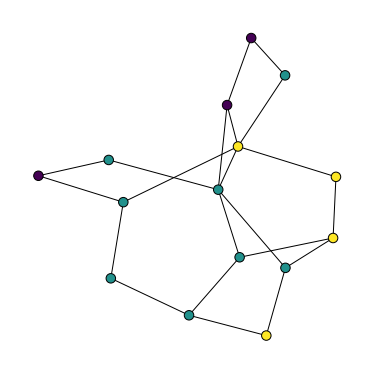

In [4]:
G = create_sparse_connected_graph(
    num_nodes=15,
    extra_edges=7,
    alphabet_size=3,
    n_dim_vector_attribute=3)
G1 = G.copy()

draw_graph(G1)

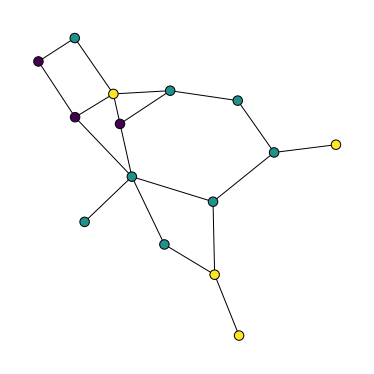

In [5]:
import random
edges = list(G.edges())
edges_to_remove = random.sample(edges, 3)
G.remove_edges_from(edges_to_remove)
G2 = G.copy()

draw_graph(G2)

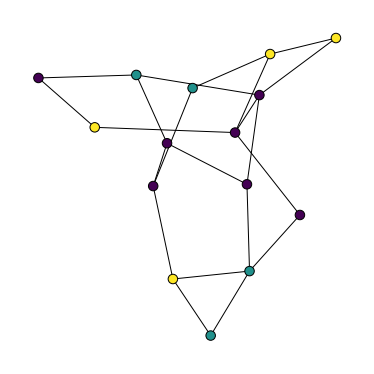

In [6]:
G3 = create_sparse_connected_graph(
    num_nodes=15,
    extra_edges=7,
    alphabet_size=3,
    n_dim_vector_attribute=3)

draw_graph(G3)

We vectorize the graphs and obtain a vector representation that confirms that G1 and G2 are more similar than G3

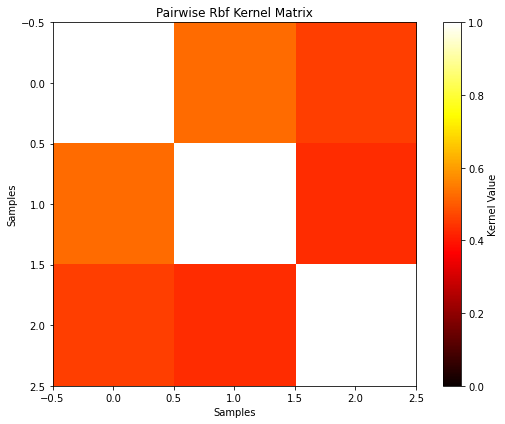

In [7]:
from nsppk import NSPPK
graph_vectorizer = NSPPK(radius=1, distance=4, connector=1, nbits=10, dense=True)
X = graph_vectorizer.fit_transform([G1,G2,G3])
plot_similarity_kernel(X)

We can node vectorize the graphs and obtain a list of data matrices each with size n_rows = n_nodes and n_cols = n_features = $2^{nbits}$

In [12]:
from nsppk import NodeNSPPK
node_graph_vectorizer = NodeNSPPK(radius=1, distance=4, connector=1, nbits=10, dense=True)
mtx_list = node_graph_vectorizer.fit_transform([G1,G2,G3])
mtx_list[0]

array([[1, 2, 0, ..., 0, 0, 0],
       [1, 3, 1, ..., 0, 0, 0],
       [1, 2, 0, ..., 0, 0, 0],
       ...,
       [1, 3, 0, ..., 0, 0, 0],
       [1, 2, 1, ..., 0, 0, 0],
       [1, 2, 0, ..., 0, 0, 0]])

Note that:

1. the sum of all node encodings is the graph encoding 
2. the feature with index 0 is always 1 for every node, and it will be the number of nodes for the graph encoding
3. the feature with index 1 is the corresponding node degree, and it will be 2*number of edges for the graph encoding


In [10]:
sum(X[0] - mtx_list[0].sum(axis=0))

0

**Note:** a graph need to have both node and edge attribute 'label', otherwise an exception is raised.

In [ ]:
G = nx.Graph()
G.add_node(1)
G.add_node(2)
G.add_edge(1,2)
NSPPK(radius=1, distance=4, connector=1, nbits=10, dense=True).fit_transform([G])

---